# Face verification

### Goals
- train a network for face similarity using triplet loss
- work data augmentation, generators and hard negative mining

### Dataset

- We will be using Labeled Faces in the Wild (LFW) dataset available openly at http://vis-www.cs.umass.edu/lfw/
- For computing purposes, we'll only restrict ourselves to a subpart of the dataset. You're welcome to train on the whole dataset on GPU, by changing the PATH in the following cells, and in data download
- We will also load pretrained weights


In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
import keras
import os
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Concatenate, merge, Lambda, Dot
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from keras import optimizers
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Processing the dataset

**This part is similar to previous notebook on siamese nets, you may just run the cells to get the necessary inputs**

The dataset consists of folders corresponding to each identity. The folder name is the name of the person.
We map each class (identity) to an integer id, and build mappings as dictionaries `name_to_classid` and `classid_to_name`

Set USE_SUBSET to False if you want to use the full dataset (GPU only!)

In [3]:
PATH = "lfw/lfw-deepfunneled/"
USE_SUBSET = False

In [4]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = dirs[:500]
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

number of classes: 5749


In each directory, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries:
- mappings from imagepath and image id: `path_to_id` and `id_to_path`
- mappings from class id to image ids: `classid_to_ids` and `id_to_classid`

In [5]:
# read all directories
img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(PATH+directory))] 
             for directory,c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v:k for k,v in enumerate(all_images_path)}
id_to_path = {v:k for k,v in path_to_id.items()}

In [6]:
# build mappings between images and class
classid_to_ids = {k:[path_to_id[path] for path in v] for k,v in img_paths.items()}
id_to_classid = {v:c for c,imgs in classid_to_ids.items() for v in imgs}

The following histogram shows the number of images per class: there are many classes with only one image. 
These classes are useful as negatives, only as we can't make a positive pair with them.

Now that we have a way to compute the pairs, let's open all the possible images. It will expand all the images into RAM memory. There are more than 1000 images, so 100Mo of RAM will be used, which will not cause any issue.

_Note: if you plan on opening more images, you should not open them all at once, and rather build a generator_

In [7]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(PATH+path)),0)]
    return np.vstack(all_imgs)


In [8]:
all_imgs = open_all_images(id_to_path)
mean = np.mean(all_imgs, axis=(0,1,2))
all_imgs -= mean
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

((13233, 60, 60, 3), '1143.3312Mo')

The following function builds a large number of positives/negatives pairs (train and test)

# Triplet loss

In the triplet loss model, we'll define 3 inputs $(a,+,-)$ for anchor, positive and negative.

#### Usage and differences with siamese nets

We release the hard constraint that all data of the same class should be squashed to a single point. Rather, images representation can live on a manifold, as long as they are closer to similar class images than to different class images

On large datasets, with careful hyperparameters, triplets and more advances metric learning method beat siamese nets

#### Outline

We will build positive pairs, and find a way to sample negatives to obtain triplets
Note that we don't need outputs anymore (positive vs negative), we're just building triplets

In [9]:
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j]) for i in range(len(imgs)) for j in range(i+1,len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]


In [10]:
def build_positive_pairs(class_id_range):
    listX1 = []
    listX2 = []
    
    for class_id in class_id_range:
        pos = build_pos_pairs_for_id(class_id)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
    perm = np.random.permutation(len(listX1))
    return np.array(listX1)[perm], np.array(listX2)[perm]

In [11]:
split_num = int(num_classes * 0.8)

In [13]:
Xa_train, Xp_train = build_positive_pairs(range(0, split_num))
Xa_test, Xp_test = build_positive_pairs(range(split_num, num_classes-1))

# Gather the ids of all images that are used for train and test
all_img_train_idx = list(set(Xa_train) | set(Xp_train))
all_img_test_idx = list(set(Xa_test) | set(Xp_test))

We end up with 1177 different pairs, which we'll append with a random sample (as negative) in the generator

In [14]:
Xa_train.shape, Xp_train.shape

((12018,), (12018,))

In [15]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
])

In [16]:
class TripletGenerator():
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx):
        self.cur_img_index=0
        self.cur_img_pos_index=0
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train
        self.Xp = Xp_train
        self.cur_train_index = 0
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            # fill one batch
            imgs_a = self.Xa[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_p = self.Xp[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_n = random.sample(self.neg_imgs_idx,imgs_a.shape[0])
            
       # deactivate augmentation
       #     yield ([self.imgs[imgs1], self.imgs[imgs2]],
       #             self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])
        
            yield ([seq.augment_images(self.imgs[imgs_a]), 
                    seq.augment_images(self.imgs[imgs_p]),
                    seq.augment_images(self.imgs[imgs_n])
                    ],
                    # placeholders for output, won't be needed 
                    np.zeros(shape=(imgs_a.shape[0]))
                )


In [17]:
batch_size = 128
gen = TripletGenerator(Xa_train, Xp_train, batch_size, all_imgs, all_img_train_idx)

In [18]:
[xa, xp, xn], y = next(gen.next_train())

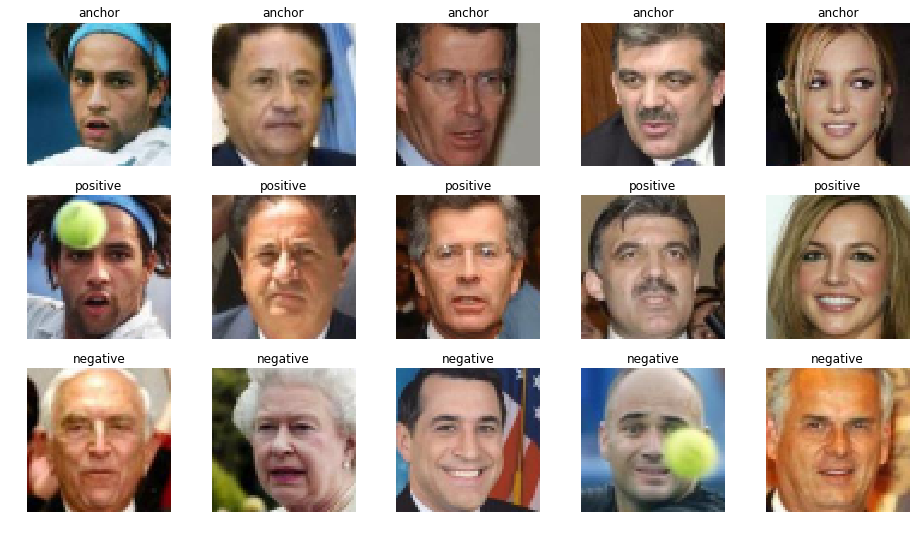

In [19]:
plt.figure(figsize=(16, 9))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.title("anchor")
    plt.imshow((xa[i] + mean) / 255)
    plt.axis('off')
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.title("positive")
    plt.imshow((xp[i] + mean) / 255)
    plt.axis('off')
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.title("negative")
    plt.imshow((xn[i] + mean) / 255)
    plt.axis('off')
plt.show()

In [20]:
gen_test = TripletGenerator(Xa_test, Xp_test, batch_size, all_imgs, all_img_test_idx)

## Triplet Model

The loss of the triplet model is as follows: 

$$ max(0, ||x_a - x_p||_2 - ||x_a - x_n||_2 + \alpha)$$

We'll be using cosine similarities instead of euclidean distances (seems to be working a bit better in that case), so the loss becomes:

$$ max(0, cos(x_a, x_n) - cos(x_a - x_p) + \alpha)$$


In [21]:
# Build a loss which doesn't take into account the y_true, as
# we'll be passing only 0
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

# The real loss is here
def cosine_triplet_loss(X):
    _alpha = 0.5
    positive_sim, negative_sim = X
    
    # batch loss
    losses = K.maximum(0.0, negative_sim - positive_sim + _alpha)
    
    return K.mean(losses)

## Shared Convolutional Network

- You may as well build your own

In [22]:
inp = Input((60,60,3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 30,30
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 15,15
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 8,8
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="tanh")(x)
x = Dropout(0.2)(x)
x = Dense(64)(x)
shared_conv2 = Model(inputs=inp, outputs = x)

### Triplet Model

**Exercise**

- Build the triplet model, using the skeleton below
- First run the 3 inputs through the shared conv
- Then compute positive and negative similarities
- Then call the triplet loss function using a `Lambda` layer
- There are other ways to do it, however Keras API is not perfect for triplets

In [ ]:
anchor = Input((60, 60, 3), name='anchor')
positive = Input((60, 60, 3), name='positive')
negative = Input((60, 60, 3), name='negative')

# TODO

In [24]:

anchor = Input((60, 60, 3), name='anchor')
positive = Input((60, 60, 3), name='positive')
negative = Input((60, 60, 3), name='negative')

a = shared_conv2(anchor)
p = shared_conv2(positive)
n = shared_conv2(negative)

pos_sim = Dot(axes=-1, normalize=True)([a,p])
neg_sim = Dot(axes=-1, normalize=True)([a,n])

loss = Lambda(cosine_triplet_loss,
              output_shape=(1,))(
             [pos_sim,neg_sim])

model_triplet = Model(
    inputs=[anchor, positive, negative],
    outputs=loss)

model_triplet.compile(loss=identity_loss, optimizer="rmsprop")


In [25]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


best_model_fname = "triplet_checkpoint_b2.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss',
                                save_best_only=True, verbose=1)

*Warning* 
- You will need to run on GPU if you're on the large dataset
- On the small dataset, the model sometimes takes a few epochs before starting to decrease the loss
- This can be due to the init, learning rate, or too much dropout / augmentation

In [26]:
history = model_triplet.fit_generator(generator=gen.next_train(), 
                    steps_per_epoch=Xa_train.shape[0] // batch_size, 
                    epochs=2,
                    validation_data = gen_test.next_train(),
                    validation_steps=Xa_test.shape[0] // batch_size,
                    callbacks=[best_model_cb])

Epoch 1/2
93/93 [==============================] - 369s 4s/step - loss: 0.4989 - val_loss: 0.5001

Epoch 00001: val_loss improved from inf to 0.50015, saving model to triplet_checkpoint_b2.h5
Epoch 2/2
93/93 [==============================] - 374s 4s/step - loss: 0.4985 - val_loss: 0.4925

Epoch 00002: val_loss improved from 0.50015 to 0.49245, saving model to triplet_checkpoint_b2.h5


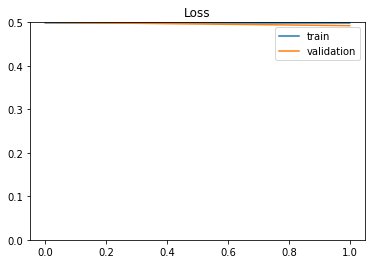

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 0.5)
plt.legend(loc='best')
plt.title('Loss');

In [ ]:
model_triplet.load_weights("triplet_checkpoint_b2.h5")

** Exercise **
- What do you observe? 
- Try to make changes to the model / parameters to get a better convergence
- Try to add data augmentation, or increase the size of the training set
- You might want to be on GPU for testing several architectures, even on the small set

In [28]:
# You may load this model
# Trained on triplets but with larger dataset
# Far from perfect ! 
model_triplet.load_weights("triplet_pretrained.h5")

## Displaying similar images

In [29]:
emb = shared_conv2.predict(all_imgs)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [33]:
def euclidean(idx1,idx2):
    return np.linalg.norm(emb[idx1] - emb[idx2])

def cosine(idx1, idx2):
    return np.dot(emb[idx1], emb[idx2])

In [34]:
def most_sim(x, emb, topn=5, mode="cosine"):
    if mode == "cosine":
        x = x / np.linalg.norm(x)
        sims = np.dot(emb, x)
        ids = np.argsort(sims)[::-1]
        return [(id,sims[id]) for id in ids[:topn]]
    else:
        dists = np.linalg.norm(emb - x, axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]

In [35]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

5441


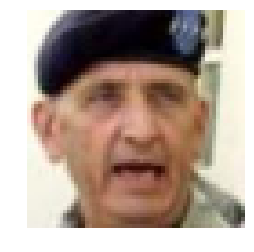

('Tommy_Franks', 12357, 1.0)


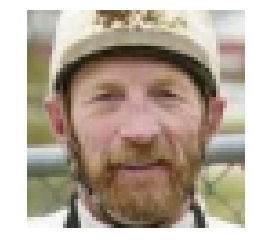

('Perry_Compton', 10079, 1.0)


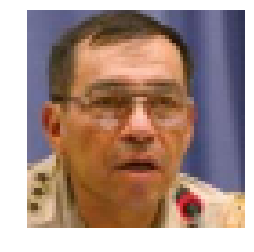

('Ricardo_Sanchez', 10588, 0.99229968)


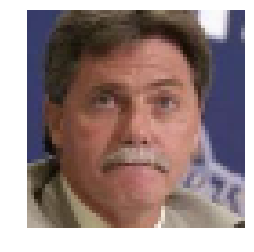

('Doug_Melvin', 3171, 0.99229968)


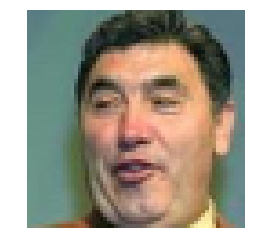

('Eddy_Merckx', 3229, 0.99229968)


In [36]:
interesting_classes = list(filter(lambda x: len(x[1])>4, classid_to_ids.items()))
class_idx = random.choice(interesting_classes)[0]
print(class_idx)
img_idx = random.choice(classid_to_ids[class_idx])
for id, sim in most_sim(emb[img_idx], emb):
    display(all_imgs[id] + mean)
    print((classid_to_name[id_to_classid[id]], id, sim))

## Test Recall@k model

for each test class with > 1 image, pick image at random, and compute similarity with all other test images
compute recall @k: is the correct class within the k first images

In [37]:
test_ids = []
for class_id in range(split_num, num_classes-1):
    img_ids = classid_to_ids[class_id]
    if len(img_ids) > 1:
        test_ids += img_ids

In [38]:
print(len(test_ids))

1771


In [39]:
len([len(classid_to_ids[x]) for x in list(range(split_num, num_classes-1)) if len(classid_to_ids[x])>1])

334

In [40]:
def recall_k(k=10):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = [id_to_classid[x] for (x, score) in most_sim(emb[img_idx], emb, topn=k+1)[1:]]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)


In [41]:
def random_recall_k(k=10):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = [id_to_classid[x] for x in random.sample(list(set(test_ids) - {img_idx}), k)]
        #found_classes = [id_to_classid[x] for (x, score) in most_sim(norm_emb[img_idx], norm_emb, topn=k+1)[1:]]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)


In [42]:
recall_k(k=10)

0.31733483907396953

In [43]:
random_recall_k(k=10)

0.10897797854319594

## Hard Negative Mining

We'll mine negatives based on previous epoch's model. To do so, we'll compute distances with all anchors, and sample among the most similar negatives, but not the too difficult ones

In [ ]:
# Naive way to compute all similarities between all images. May be optimized!
def build_similarities(conv, all_imgs):
    embs = conv.predict(all_imgs)
    embs = embs / np.linalg.norm(embs, axis=-1, keepdims=True)
    all_sims = np.dot(embs, embs.T)
    return all_sims

def intersect(a, b):
    return list(set(a) & set(b))

def build_negatives(anc_idxs, pos_idxs, similarities, neg_imgs_idx, num_retries=20):
    # If no similarities were computed, return a random negative
    if similarities is None:
        return random.sample(neg_imgs_idx,len(anc_idxs))
    final_neg = []
    # for each positive pair
    for (anc_idx, pos_idx) in zip(anc_idxs, pos_idxs):
        anchor_class = id_to_classid[anc_idx]
        #positive similarity
        sim = similarities[anc_idx, pos_idx]
        # find all negatives which are semi(hard)
        possible_ids = np.where((similarities[anc_idx] + 0.25) > sim)[0]
        possible_ids = intersect(neg_imgs_idx, possible_ids)
        appended = False
        for iteration in range(num_retries):
            if len(possible_ids) == 0:
                break
            idx_neg = random.choice(possible_ids)
            if id_to_classid[idx_neg] != anchor_class:
                final_neg.append(idx_neg)
                appended = True
                break
        if not appended:
            final_neg.append(random.choice(neg_imgs_idx))
    return final_neg

In [ ]:
class HardTripletGenerator():
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx, conv):
        self.cur_img_index=0
        self.cur_img_pos_index=0
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train
        self.Xp = Xp_train
        self.cur_train_index = 0
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx
        self.all_anchors = list(set(Xa_train))
        self.mapping_pos = {v:k for k,v in enumerate(self.all_anchors)}
        self.mapping_neg = {k:v for k,v in enumerate(self.neg_imgs_idx)}
        if conv:
            self.similarities = build_similarities(conv, self.imgs)
        else:
            self.similarities = None
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            # fill one batch
            imgs_a = self.Xa[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_p = self.Xp[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_n = build_negatives(imgs_a, imgs_p, self.similarities, self.neg_imgs_idx)
       # deactivate augmentation
       #     yield ([self.imgs[imgs1], self.imgs[imgs2]],
       #             self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])
        
            yield ([seq.augment_images(self.imgs[imgs_a]), 
                    seq.augment_images(self.imgs[imgs_p]),
                    seq.augment_images(self.imgs[imgs_n])
                    ],
                    np.zeros(shape=(imgs_a.shape[0]))
                )


In [ ]:
batch_size = 128

In [ ]:
gen_hard = HardTripletGenerator(Xa_train, Xp_train, batch_size, all_imgs, all_img_train_idx, shared_conv2)

In [ ]:
len(all_img_train_idx)

In [ ]:
[xa, xp, xn], y = next(gen_hard.next_train())

In [ ]:
plt.figure(figsize=(16, 9))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.title("anchor")
    plt.imshow((xa[i] + mean) / 255)
    plt.axis('off')
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.title("positive")
    plt.imshow((xp[i] + mean) / 255)
    plt.axis('off')
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.title("negative")
    plt.imshow((xn[i] + mean) / 255)
    plt.axis('off')
plt.show()

In [ ]:
inp = Input((60,60,3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 30,30
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 15,15
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 8,8
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="tanh")(x)
x = Dense(50)(x)
shared_conv2 = Model(inputs=inp, outputs = x)

In [ ]:
anchor = Input((60, 60, 3), name='anchor')
positive = Input((60, 60, 3), name='positive')
negative = Input((60, 60, 3), name='negative')

a = shared_conv2(anchor)
p = shared_conv2(positive)
n = shared_conv2(negative)

pos_sim = Dot(axes=-1, normalize=True)([a,p])
neg_sim = Dot(axes=-1, normalize=True)([a,n])

loss = Lambda(cosine_triplet_loss,
              output_shape=(1,))(
             [pos_sim,neg_sim])

model_triplet = Model(
    inputs=[anchor, positive, negative],
    outputs=loss)

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_triplet.compile(loss=identity_loss, optimizer=opt)


In [ ]:
gen_test = TripletGenerator(Xa_test, Xp_test, batch_size, all_imgs, all_img_test_idx)

In [ ]:
# At first epoch we don't generate hard triplets
gen_hard = HardTripletGenerator(Xa_train, Xp_train, batch_size, all_imgs, all_img_train_idx, None)

In [ ]:
nb_epochs = 10
for epoch in range(nb_epochs):
    print("built new hard generator for epoch "+str(epoch))
    model_triplet.fit_generator(generator=gen_hard.next_train(), 
                    steps_per_epoch=Xa_train.shape[0] // batch_size, 
                    epochs=1,
                    validation_data = gen_test.next_train(),
                    validation_steps=Xa_test.shape[0] // batch_size)
    gen_hard = HardTripletGenerator(Xa_train, Xp_train, batch_size, all_imgs, all_img_train_idx, shared_conv2)

In [ ]:
emb = shared_conv2.predict(all_imgs)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [ ]:
recall_k(k=10)

In [ ]:
random_recall_k(k=10)